# Analyze Sentiment for Forum Data
This notebook loads the sentiment data and explores results

## Data Sources
- youbemom-merged.db (with sentiment scores from 2.0-Sentiment-Create_Scores.ipynb)

## Changes
- 2020-12-13: Created

## Database Structure
- threads
 - id: automatically assigned
 - url: url of top post
 - subforum: subforum of post
 - dne: post does not exist
- posts
 - id: automatically assigned
 - family_id: thread->id
 - message_id: the unique id of the message from the html
 - parent_id: id of post this post is responding to, 0 if top post
 - date_recorded: date the data is fetched
 - date_created: date the data was created
 - title: title of the post
 - body: body of the post
 - subforum: subforum of post
 - deleted: has post been deleted

## TODO
- Does python have a regression function for continuous dependent variables between 0 and 1 or will I have to use R/Stata for a fractional regression model?
- Set up functions for the plots so I can plug in the variable I want to see
- Does sentiment differ between parents and children in threads?
 - Is sentiment more negative after negative posts? More positive after positive posts?
- Is there a time-dependent function here?
 - Seasonality?
 - Does tweaking the time period cutoffs affect the significance?
- Frequency distribution of words
- Robustness checks of different samples
- Scrape the rest of December so frequency counts are right

## Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import ttest_ind, kde
from datetime import datetime
# from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer #, word_tokenize
from nltk.corpus import stopwords
import string
import re
from pathlib import Path
import matplotlib.pyplot as plt
import math
from statsmodels.formula.api  import ols
from youbemom import create_connection

## Functions

In [2]:
def ttest_sentiment(df, v):
    """ run a t-test on the sentiment scores for
        before and during the pandemic
    :param df: data frame
    :param v: the variable name to t-test on
    :return: nothing, prints ttest results
    """
    group_before = df.where(df['before'])[v].dropna()
    group_during = df.where(df['during'])[v].dropna()
    result = ttest_ind(group_before, group_during, equal_var=False, nan_policy="omit")
    print('\n')
    l = len(v)
    print(' '*(l - 8) + 'variable    before    during statistic    pvalue')
    print(v + '  {:1.6f}  {:1.6f} {:+1.6f}  {:1.6f}'.format(group_before.mean(), group_during.mean(), result.statistic, result.pvalue))

In [3]:
def format_data(df):
    """ format the data frame from sql so dates are in
        datetime format and booleans are bools not ints
    :param df: data frame
    :return df: formatted data frame
    """
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['date_created'] = pd.to_datetime(df['date_created'])
    df['is_parent'] = df['is_parent'] == 1
    df['deleted'] = df['deleted'] == 1
    df['before'] = df['before'] == 1
    df['during'] = df['during'] == 1
    df['march'] = df['march'] == 1
    return df

In [4]:
def compare_parent_child(df):
    parents = df[df["is_parent"]]
    parents = parents[["family_id","neg_sentiment","pos_sentiment","compound_sentiment"]]
    children = df[~df["is_parent"]]
    children = children[["family_id","neg_sentiment","pos_sentiment","compound_sentiment"]]
    children_ave = children.groupby("family_id", as_index=False).mean()
    compare = pd.merge(left=parents, right=children_ave, on="family_id", how="inner", suffixes=['_p','_c'])
    compare['pos_diff'] = compare['pos_sentiment_p'] - compare['pos_sentiment_c']
    compare['neg_diff'] = compare['neg_sentiment_p'] - compare['neg_sentiment_c']
    compare['compound_diff'] = compare['compound_sentiment_p'] - compare['compound_sentiment_c']
    return compare

In [5]:
def season_sentiment(df, name, var):
    grouping_ave = df.groupby([var])['compound_sentiment'].mean()
    path_sen = path_parent / "clean_data" / "sentiment_{0}_{1}.csv".format(name, var)
    path_sen = str(path_sen)
    grouping_ave.to_csv(path_sen)
    print(grouping_ave)

In [25]:
def season_freq(df, name, var):
    grouping_freq = df.groupby(var)[var].count()
    path_freq = path_parent / "clean_data" / "frequency_{0}_{1}.csv".format(name, var)
    path_freq = str(path_freq)
    grouping_freq.to_csv(path_freq)
    print(grouping_freq)

In [33]:
def ave_sent_day(df):
    df['date'] = pd.to_datetime(df['date_created'], format="%Y-%m-%d")
    daily_ave = df.resample('d', on='date').mean().dropna(how='all')
    daily_ave['before'] = daily_ave.index <= pd.Timestamp(2020,2,28)
    daily_ave['during'] = daily_ave.index >= pd.Timestamp(2020,4,1)
    daily_ave['march'] = ~daily_ave['before'] & ~daily_ave['during']
    return daily_ave

## File Locations

In [6]:
p = Path.cwd()
path_parent = p.parents[0]

In [7]:
path_db = path_parent / "database" / "youbemom-merged.db"
path_db = str(path_db)

## Load Data
Counts of posts in each subforum

In [8]:
counts_sql = '''
    SELECT subforum, COUNT(family_id), MIN(date_created), MAX(date_created)
    FROM posts
    GROUP BY subforum
'''

In [9]:
conn = create_connection(path_db)
counts = pd.read_sql_query(counts_sql, conn)

In [10]:
counts.head(16)

,subforum,COUNT(family_id),MIN(date_created),MAX(date_created)
0,boston,230,2018-01-27 17:21:00,2020-11-23 00:23:00
1,chicago,193,2018-03-05 14:40:00,2020-12-08 13:50:30
2,elementary,3543,2013-12-05 21:43:00,2020-11-30 20:52:00
3,expecting,872,2018-01-24 02:43:00,2020-11-23 21:01:00
4,los-angeles,263,2018-01-09 20:58:00,2020-12-02 02:07:00
5,new-york-city,6297,2018-01-07 11:37:00,2020-11-28 03:45:00
6,newborn,2036,2013-11-06 20:55:00,2020-11-29 23:39:00
7,nyc-schools,2211,2018-01-01 16:03:00,2020-12-04 16:49:00
8,preschool,3000,2013-12-10 03:58:00,2020-11-23 14:34:00
9,single-parents,337,2018-02-07 11:29:00,2020-11-23 16:22:00


Special needs subforum

In [11]:
sn_sql = ''' SELECT * FROM posts WHERE subforum="special-needs" '''

In [12]:
sn = pd.read_sql_query(sn_sql, conn)

In [13]:
sn = format_data(sn)

Toddler subforum: generate a 10% sample of family_ids to make processing easier

In [14]:
td_ids_sql = ''' SELECT family_id FROM threads WHERE subforum="toddler" '''

In [15]:
td_ids = pd.read_sql_query(td_ids_sql, conn)

In [16]:
id_10per_sample = td_ids.sample(frac = 0.1, random_state = 281)

In [17]:
temp_table_sql = ''' CREATE TEMPORARY TABLE temp(id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, family_id INTEGER); '''

In [18]:
cur = conn.cursor()
cur.execute(temp_table_sql)

In [19]:
id_10per_sample.to_sql('temp', conn, if_exists='append', index=False)

In [20]:
td_sql = ''' 
    SELECT * 
    FROM posts 
    WHERE subforum="toddler" 
        AND family_id IN (SELECT family_id FROM temp)
'''

In [21]:
td = pd.read_sql_query(td_sql, conn)

In [22]:
td = format_data(td)

## Compare Sentiment

### 1. Subsets in correct date range: 2018-01-01 to 2020-11-30

In [23]:
mask = (td['date_created'] >= pd.Timestamp(2018, 1, 1, 0, 0, 0)) & (td['date_created'] < pd.Timestamp(2020, 12, 1, 0, 0, 0))
td_sub = td.loc[mask]

In [24]:
mask = (sn['date_created'] >= pd.Timestamp(2018, 1, 1, 0, 0, 0)) & (sn['date_created'] < pd.Timestamp(2020, 12, 1, 0, 0, 0))
sn_sub = sn.loc[mask]

### 2. Comparing sentiment before and during pandemic with a t-test

In [ ]:
for df in [sn_sub, td_sub]:
    print("\nGROUP\n")
    ttest_sentiment(df, 'neg_sentiment')
    ttest_sentiment(df, 'neu_sentiment')
    ttest_sentiment(df, 'pos_sentiment')
    ttest_sentiment(df, 'compound_sentiment')

In [ ]:
for df in [sn_sub, td_sub]:
    fig, ax = plt.subplots()
    width = 0.35
    sentiments = ['Negative', 'Positive']
    x_pos = np.arange(len(sentiments))

    before_mean = [df["neg_sentiment"][df['before']].mean(),
                   df["pos_sentiment"][df['before']].mean()]
    before_se = [df["neg_sentiment"][df['before']].std()/math.sqrt(len(df["neg_sentiment"][df['before']])),
                 df["pos_sentiment"][df['before']].std()/math.sqrt(len(df["pos_sentiment"][df['before']]))]
    during_mean = [df["neg_sentiment"][df['during']].mean(),
                   df["pos_sentiment"][df['during']].mean()]
    during_se = [df["neg_sentiment"][df['during']].std()/math.sqrt(len(df["neg_sentiment"][df['during']])),
                 df["pos_sentiment"][df['during']].std()/math.sqrt(len(df["pos_sentiment"][df['during']]))]

    rects_before = ax.bar(x_pos - width/2, before_mean, width, yerr=before_se,
                    label='Before', capsize=5, color="cornflowerblue")
    rects_during = ax.bar(x_pos + width/2, during_mean, width, yerr=during_se,
                    label='During', capsize=5, color="indianred")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Average Sentiment Score\n(normalized 0 to 1)')
    ax.set_title('Comparison of Sentiment Scores')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sentiments)
    ax.legend()
    fig.tight_layout()
#     plt.savefig('../plots/sentiment_neg_pos.png')
    plt.show()

### 3. Comparing sentiment of parent and child posts

In [ ]:
for df in [sn_sub, td_sub]:
    print("\nGROUP\n")
    compare = compare_parent_child(df)
    est_pos = ols(formula = 'pos_sentiment_c ~ pos_sentiment_p', data = compare).fit()
    print(est_pos.summary())
    est_neg = ols(formula = 'neg_sentiment_c ~ neg_sentiment_p', data = compare).fit()
    print(est_neg.summary())
    est_compound = ols(formula = 'compound_sentiment_c ~ compound_sentiment_p', data = compare).fit()
    print(est_compound.summary())

So this suggests if a parent comment's negative sentiment increases, the children's negative sentiment will increase as well. Perhaps redo this analysis on each observation rather than the average children's sentiment.

### 4. Compare density of compound sentiment

In [ ]:
for df in [sn_sub, td_sub]:
    density_before = kde.gaussian_kde(df["compound_sentiment"][df['before']])
    density_march = kde.gaussian_kde(df["compound_sentiment"][df['march']])
    density_during = kde.gaussian_kde(df["compound_sentiment"][df['during']])
    x = np.arange(-1.0, 1.0, 0.01)
    plt.scatter(x, density_before(x), alpha=0.5, label="Before")
    plt.scatter(x, density_march(x), alpha=0.5, label="March")
    plt.scatter(x, density_during(x), alpha=0.5, label="During")
    plt.legend(loc="upper right")
    plt.show()

C:\Users\mwhuhn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


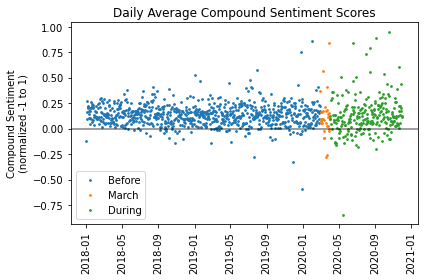

C:\Users\mwhuhn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


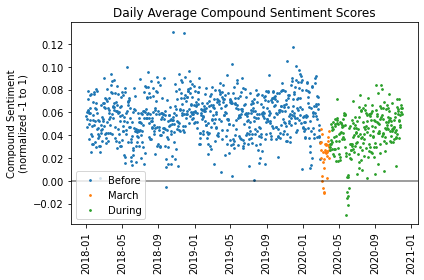

In [34]:
size = 3
for df in [sn_sub, td_sub]:
    daily_ave = ave_sent_day(df)
#     print(daily_ave[daily_ave['during']].sort_values(by='compound_sentiment', ascending=False).head(20))
    plt.scatter(daily_ave.index[daily_ave['before']], daily_ave['compound_sentiment'][daily_ave['before']], label="Before", s=size)
    plt.scatter(daily_ave.index[daily_ave['march']], daily_ave['compound_sentiment'][daily_ave['march']], label="March", s=size)
    plt.scatter(daily_ave.index[daily_ave['during']], daily_ave['compound_sentiment'][daily_ave['during']], label="During", s=size)
    plt.legend(loc="lower left")
    plt.xticks(rotation=90)
    plt.ylabel('Compound Sentiment\n(normalized -1 to 1)')
    plt.title('Daily Average Compound Sentiment Scores')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.tight_layout()
    # plt.savefig('../plots/daily_ave_compound_sentiment.png')
    plt.show()

### 5. Compare post frequency over same period for special needs and toddler subforums

Sentiment

In [ ]:
season_sentiment(sn_sub, "special-needs", "weekday")
season_sentiment(sn_sub, "special-needs", "month")
season_sentiment(sn_sub, "special-needs", "week_n")

In [ ]:
season_sentiment(td_sub, "toddler", "weekday")
season_sentiment(td_sub, "toddler", "month")
season_sentiment(td_sub, "toddler", "week_n")

Frequency

In [27]:
season_freq(sn_sub, "special-needs", "weekday")
season_freq(sn_sub, "special-needs", "month")
season_freq(sn_sub, "special-needs", "week_n")

weekday
Friday        7476
Monday        9005
Saturday      5497
Sunday        5863
Thursday      9386
Tuesday      10671
Wednesday    10336
Name: weekday, dtype: int64
month
April        4928
August       3725
December     3955
February     6793
January      7042
July         3487
June         4695
March        6226
May          4732
November     4279
October      4500
September    3872
Name: month, dtype: int64
week_n
1     1095
2     1702
3     1604
4     1674
5     1610
6     2123
7     1724
8     1245
9     1842
10    1800
11    1645
12    1108
13    1055
14    1517
15     722
16     990
17    1145
18    1321
19    1163
20     906
21    1046
22    1178
23    1202
24    1096
25    1180
26     791
27     663
28     804
29     745
30     979
31     639
32     685
33     759
34     812
35    1198
36     911
37    1013
38     862
39     864
40     959
41    1016
42    1036
43    1022
44    1020
45     916
46    1297
47     766
48    1092
49     982
50    1251
51     996
52     463
Name

In [28]:
season_freq(td_sub, "toddler", "weekday")
season_freq(td_sub, "toddler", "month")
season_freq(td_sub, "toddler", "week_n")

weekday
Friday       226658
Monday       257443
Saturday     183745
Sunday       207539
Thursday     245996
Tuesday      258161
Wednesday    255595
Name: weekday, dtype: int64
month
April        153960
August       126865
December      82452
February     136983
January      144199
July         132404
June         127005
March        170237
May          147507
November     139405
October      140080
September    134040
Name: month, dtype: int64
week_n
1     30672
2     31114
3     31990
4     32170
5     33854
6     36763
7     33589
8     30776
9     35581
10    36122
11    40712
12    39196
13    37895
14    37969
15    34743
16    36389
17    35664
18    33540
19    34049
20    35203
21    31272
22    32715
23    31249
24    29938
25    29610
26    27658
27    29013
28    29713
29    30354
30    29152
31    30716
32    28305
33    29105
34    27579
35    29475
36    30368
37    30477
38    30838
39    33741
40    31558
41    32649
42    30209
43    31600
44    31642
45    36938
46   